# 시계열 분석을 이용한 삼성전자 다음날 종가 예측

# 1. 데이터 준비:
- 분석 대상: 제공된 삼성전자 주식 데이터
- 필요 데이터: 과거 일자별 종가(Close) 데이터

In [152]:
import pandas as pd
df = pd.read_csv("Data/samsung.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df[["Close"]]
df

,Close
Date,
2000-12-13,3780
2000-12-14,3620
2000-12-15,3490
2000-12-18,3560
2000-12-19,3530
...,...
2025-04-02,58800
2025-04-03,57600
2025-04-04,56100


In [153]:
# 2022년전까지 train, 2022년후부터 test
train = df[df.index.year < 2022]
test = df[df.index.year >= 2022]

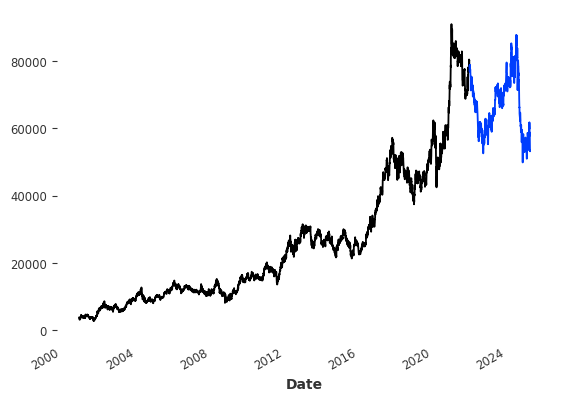

In [135]:
import matplotlib.pyplot as plt

train["Close"].plot()
test["Close"].plot()
plt.grid()
plt.show()

# 2. 모델링 및 예측:
- 오늘 수업 시간에 배운 시계열 분석 기법 중 **하나 이상**을 선택하여 적용합니다. (예: 이동평균(MA), 지수평활법(Exponential Smoothing), ARIMA 등)
- 선택한 모델을 사용하여 **다음 영업일 2025년 4월 9일 종가(Close) 값을 예측해야 합니다.**

### Naive 예측 모형

In [136]:
df["Pred"] = df["Close"].shift(1)     # 한칸씩 아래로 이동
df

,Close,Pred
Date,,
2000-12-13,3780,NaN
2000-12-14,3620,3780.0
2000-12-15,3490,3620.0
2000-12-18,3560,3490.0
2000-12-19,3530,3560.0
...,...,...
2025-04-02,58800,58800.0
2025-04-03,57600,58800.0
2025-04-04,56100,57600.0


In [137]:
df["Close"].iloc[-1]

# 나이브 예측모형 썼을 때 예측 값 = 53500

53500

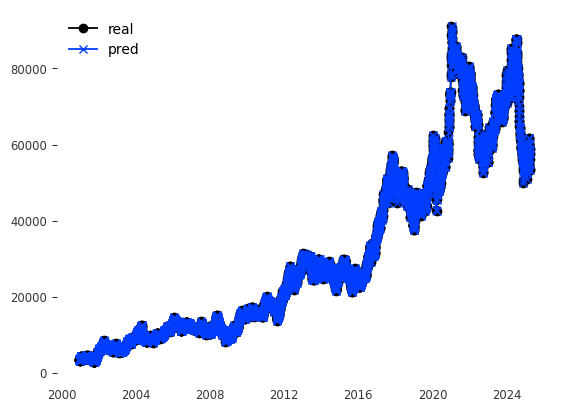

In [139]:
#df2 = df[df.index.year >= 2025]
#df2 = df[(df.index.year >= 2025) & (df.index.month >= 4)]

plt.plot(df.index, df["Close"], marker = "o")
plt.plot(df.index, df["Pred"], marker = "x")
plt.legend(["real", "pred"])
plt.grid()
plt.show()

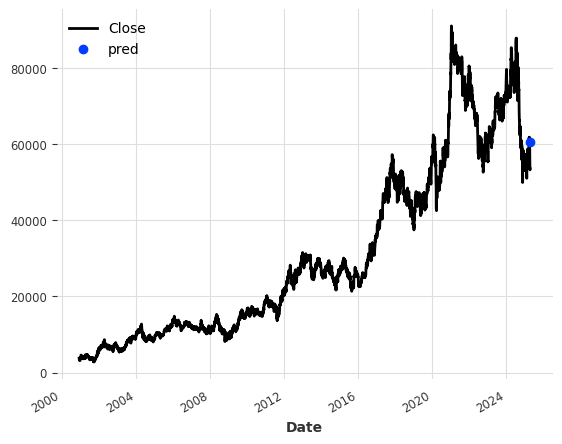

In [140]:
model = NaiveSeasonal(K=12)
model.fit(df_ts)

# 예측값 뽑기
pred = model.predict(1)

df_ts.plot()
pred.plot(label = "pred")
plt.show()

### 지수 평활법 

In [141]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
warnings.filterwarnings("ignore")

model = SimpleExpSmoothing(df["Close"]) 
fit_model = model.fit(smoothing_level=0.5) 

df["Pred"] = fit_model.fittedvalues 

fit_model.forecast(1)        

# 지수평활법 예측모형 썼을 때 예측 값 = 54344.83

5999    54344.828833
dtype: float64

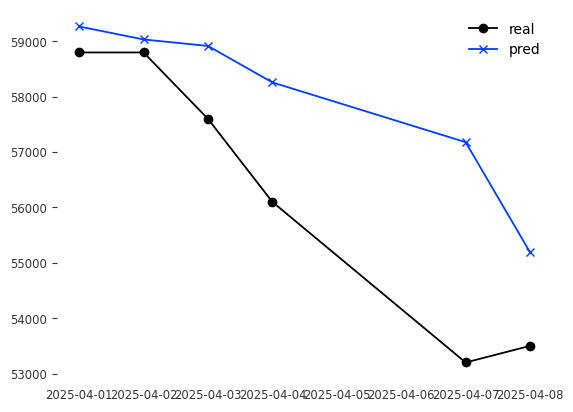

In [142]:
# df2 = df[df.index.year >= 2025] 
df2 = df[(df.index.year >= 2025) & (df.index.month >= 4)]

plt.plot(df2.index, df2["Close"], marker = "o")
plt.plot(df2.index, df2["Pred"], marker = "x")
plt.legend(["real", "pred"])
plt.grid()
plt.show()

In [149]:
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(df_ts)    # 전체데이터로 학습

pred = model.predict(1)        # 10달 후까지 예측을 해봐라
pred.values()sS

array([[53445.0506446]])

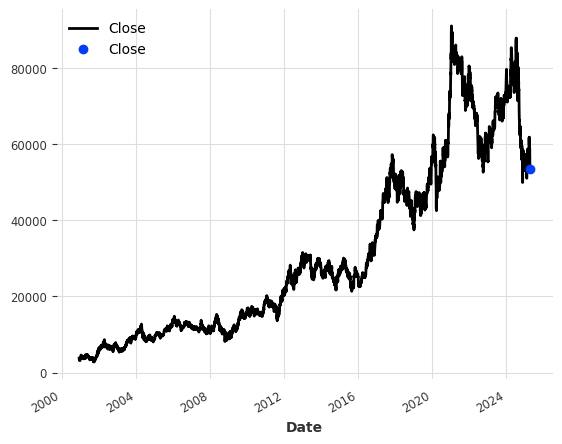

In [150]:
df_ts.plot()
pred.plot()
plt.show()

### ETS

In [101]:
df = df.asfreq('B')  # Business day 기준으로 날짜 채우기
df = df.fillna(method='ffill')  # 결측값을 앞 값으로 채움

In [103]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

train = df[df.index.year < 2022]
test = df[df.index.year >= 2022]

df_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)
train_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)
test_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)

In [159]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
future_cov = datetime_attribute_timeseries(df_ts, "day", cyclic=True, add_length=2)

# 모델 학습
from darts.models import StatsForecastAutoETS
model = StatsForecastAutoETS(season_length=5, model="ZZZ") 
model.fit(df_ts, future_covariates=future_cov)

StatsForecastAutoETS(add_encoders=None, season_length=5, model=ZZZ)

In [162]:
pred = model.predict(2, future_covariates=future_cov)
pred.values()

# ETS 예측모형 썼을 때 예측 값 = 53488.72

array([[53488.71538407],
       [53477.47258204]])

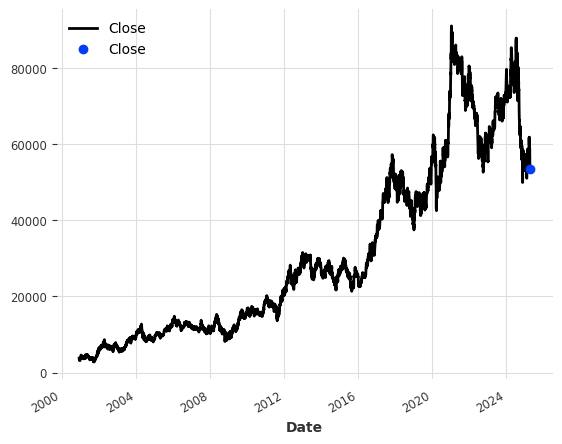

In [161]:
df_ts.plot()
pred.plot()
plt.show()

### ARIMA

In [154]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

train = df[df.index.year < 2022]
test = df[df.index.year >= 2022]

df_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)
train_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)
test_ts = TimeSeries.from_dataframe(df, value_cols=["Close"], fill_missing_dates=False)

from darts.utils.timeseries_generation import datetime_attribute_timeseries
future_cov = datetime_attribute_timeseries(df_ts, "day", cyclic=True, add_length=1)

ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.


ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.

In [130]:
# 모델 학습
from darts.models import ARIMA
model = ARIMA(5, 1, 2)
model.fit(df_ts)

ARIMA(p=5, d=1, q=2, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [131]:
# 예측
pred = model.predict(1)
pred.values()

# ARIMA 예측모형 썼을 때 예측 값 = 53691.97

array([[53691.96672466]])

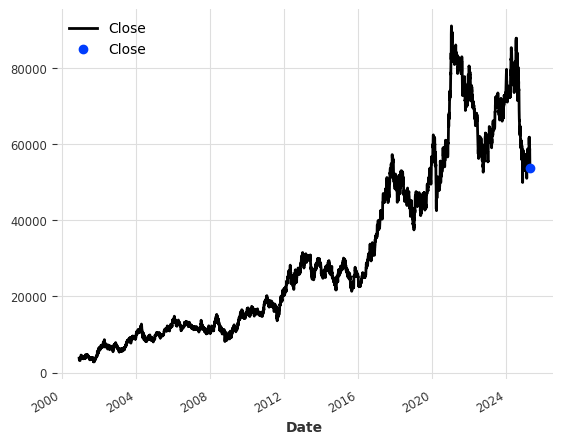

In [132]:
df_ts.plot()
pred.plot()
plt.show()